In [1]:
%load_ext autoreload

In [2]:
%autoreload
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from itertools import combinations
from scipy.stats import multivariate_normal, entropy, pearsonr
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.saliency_metrics import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale = 1.3)
%matplotlib inline

# Load paths and data

In [6]:
# load et data and models
data_path    = './../data/ETFinalCutSampleEC07/ETFinalCutSample/'
results_path = './../results/'
models_path  = './results/WK/frame_models/'

# DeepGazeII
df = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_diary.csv'))
df.columns 

Index(['ID', 'FIX_idx', 'NSS_vn', 'FIX_IN_VID', 'VIDEO_NAME', 'ET_FILE',
       'NSS_dg', 'NSS_sp', 'NSS_fg', 'FRAME_idx'],
      dtype='object')

# Plot fixed effects

In [25]:
include_pval= True
df_aux = pd.read_csv(os.path.join(models_path, 'table_Diary_10.csv')).set_index('Unnamed: 0')
df_aux.loc[['ADHDCategoryADHD-C'], ['Estimate', 'Pr(>|t|)'] if include_pval else ['Estimate']].values.tolist()[0]

[0.0797110970123115, 0.723607662673441]

In [87]:
def create_coefficients_table(models_path=models_path, coef_name=['ADHDCategoryADHD-C'], include_pval=True):
    """
    coef_name (list(str)) values: Age, Sex1, IQ, EHQ_TotalAmbidextrous, EHQ_TotalLefthanded, samplingRate120,
                            ADHDCategoryADHD-C, ADHDCategoryADHD-IN, SemLevel1, ADHDCategoryADHD-C:SemLevel1,
                            ADHDCategoryADHD-IN:SemLevel1
    """
    frame_coefs = []
    for file in os.listdir(models_path):
        if file.endswith('.csv'):
            fr_number = [int(file.split('_')[-1].rstrip('.csv'))]
            
            try:
                df_aux = pd.read_csv(os.path.join(models_path,file)).set_index('Unnamed: 0')
                frame_coefs.append(fr_number +
                                    df_aux.loc[coef_name, ['Estimate', 'Pr(>|t|)'] if include_pval else ['Estimate']].values.tolist()[0])
            except:
                print(file)
                frame_coefs.append(fr_number + [0,0])
                
    #columns_names = ['Frame'] + [f'{coef}_coef', f'{coef}_pval' for coef in coef_name if include_pval]
    #else [f'{coef}_coef' for coef in coef_name]
    # TODO: Esto no va andar para el caso de mas de un coeficiente
    columns_names = ['Frame'] + [f'{coef}_coef' for coef in coef_name] + [f'{coef}_pval' for coef in coef_name]
    return pd.DataFrame(frame_coefs,columns=columns_names).sort_values(by='Frame').reset_index(drop=True)
    
def plot_coefficients_frames(models_path, coef_name):
    
    df_aux = create_coefficients_table(models_path=models_path, coef_name=coef_name)
    
    #fig, ax = plt.subplot(2,1, figsize=(10,10))
    ax1 = plt.subplot2grid((3, 2), (0, 0))
    df_aux.loc[:,coef_name[0]+'_coef'].plot(kind='hist',ax=ax1)
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
    df_aux.loc[:,coef_name[0]+'_pval'].plot(kind='hist',ax=ax2)
    ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=1)
    df_aux.loc[:,coef_name[0]+'_coef'].plot(kind='line',ax=ax3)
    ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2, rowspan=1)
    df_aux.loc[:,coef_name[0]+'_pval'].plot(kind='line',ax=ax4)

    plt.tight_layout()
    plt.show()
    #return fig, ax

In [85]:
d = create_coefficients_table()

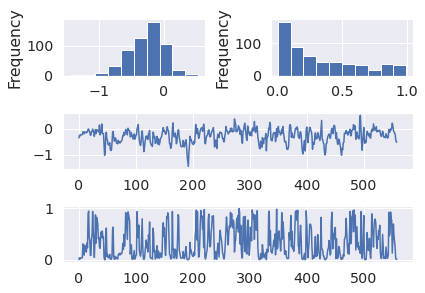

In [88]:
plot_coefficients_frames(models_path=models_path, coef_name=['ADHDCategoryADHD-IN:SemLevel1'])